# Toy model for network curvature

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from GraphRicciCurvature.FormanRicci import FormanRicci

from climnet.dataset import BaseDataset
from climnet.network import net, clim_networkx 
import climnet.grid as grid
import climnet.utils.spatial_utils as sput 
import climnet.plots as cplt
plt.style.use('paperplot.mplstyle')


In [2]:
# Parameters
grid_step = 5
save_folder = "../outputs/toyData/"


In [3]:
# Create Grid
dist_equator = grid.degree2distance_equator(grid_step)
num_points = grid.get_num_points(dist_equator)
feketeGrid = grid.FeketeGrid(num_points=num_points,
                             num_iter=100,
                            pre_proccess_type=None)
# Grid to dataarray
da_grid = xr.DataArray(data=np.ones(num_points),
                       dims=['points'],
                       coords=dict(
                           points=np.arange(0, num_points, 1),
                           lon=("points", feketeGrid.grid['lon']),
                           lat=("points", feketeGrid.grid['lat']))
                       )


Create Fekete grid with 1483 points with 100 iterations.
Initial configuration not provided. Generating random one ...


Estim100%|██████████████████████████████| 100/100 [00:09<00:00, 10.39it/s]

... Finished


In [4]:
# Location of communities on the map
da_grid_comm = [
    sput.get_locations_in_range(da_grid, lon_range=[60, 120], lat_range=[30,60]),
    sput.get_locations_in_range(da_grid, lon_range=[110, 150], lat_range=[-40,-10]),
    sput.get_locations_in_range(da_grid, lon_range=[-120, -80], lat_range=[30,60]),
    sput.get_locations_in_range(da_grid, lon_range=[-80, -40], lat_range=[-30, 0])]

comm_sizes = [np.count_nonzero(~np.isnan(da)) for da in da_grid_comm]
comm_idx_grid = np.concatenate([np.where(da.data == 1)[0] for da in da_grid_comm])
print("Community size:", comm_sizes)

Community size: [44, 38, 31, 41]


Create a random graph using stochasic block modeling with four communities:

In [60]:
# Create Stochastic Block model
probs = [[0.7, 0.02, 0.02, 0.03], 
         [0.02, 0.6, 0.02, 0.01], 
         [0.02, 0.02, 0.6, 0.02],
         [0.03, 0.01, 0.02, 0.7]]
G_sbm = nx.stochastic_block_model(comm_sizes, probs, seed=0)
G_sbm.remove_edges_from(nx.selfloop_edges(G_sbm))
A_sbm = nx.adjacency_matrix(G_sbm).todense()

/tmp/ipykernel_99526/1136695948.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_sbm = nx.adjacency_matrix(G_sbm).todense()


/tmp/ipykernel_99526/3347834751.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  X_gauss = np.random.multivariate_normal(mean, cov, length)


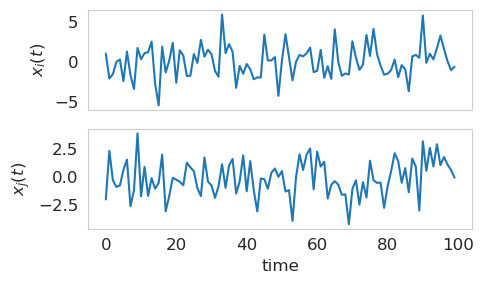

In [61]:
# Create data from Gaussian
length = int(1e3)
mean = np.zeros(A_sbm.shape[0])
cov = 1.0 * A_sbm
X_gauss = np.random.multivariate_normal(mean, cov, length)

# Plot sample
n_steps=100
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5,3))
axs[0].plot(X_gauss[:n_steps,np.random.randint(X_gauss.shape[1])])
axs[0].set_ylabel(r'$x_i(t)$')
axs[1].plot(X_gauss[:n_steps,np.random.randint(X_gauss.shape[1])])
axs[1].set_ylabel(r'$x_j(t)$')
axs[1].set_xlabel('time')

if save_folder:
    plt.savefig(save_folder + "/random_ts.png", bbox_inches='tight')

In [62]:
# Create Dataset and store to file
da_gauss = xr.DataArray(
    data=X_gauss,
    dims=['time', 'points'],
    coords=dict(
        time=np.arange(length),
        points=da_grid['points'][comm_idx_grid].data,
        lon=("points", da_grid['lon'][comm_idx_grid].data),
        lat=("points", da_grid['lat'][comm_idx_grid].data)
    ),
    name='x'
)
ds_gauss = da_gauss.to_dataset()
param_class = {
     "grid_step": grid_step,
     "grid_type": 'fekete',
     "lsm": int(0),
     "q": 0,
     "min_evs": 0,
     "min_threshold": 0,
     "th_eev": 0,
     "th": 0,
     "an": 0 
 }
ds_gauss.attrs = param_class

# Save to file
fname = "toyData.nc"
ds_gauss.to_netcdf(fname)

In [63]:
# Create BaseDataset object and save to file
ds = BaseDataset(var_name='x', load_nc=fname)

Load Dataset: toyData.nc
Variables in dataset:  x


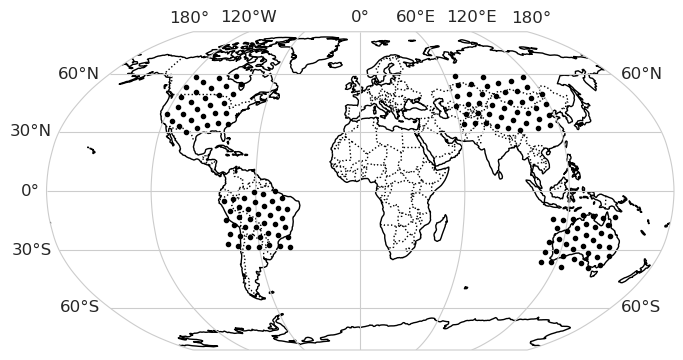

In [64]:
im = cplt.plot_map(ds, xr.where(ds.ds['x'][0], 1, 1), projection='Robinson', central_longitude=0, vmin=0, vmax=1,
                   plot_type='points', plt_grid=True, figsize=(7,4), size=3, marker='o', color='k', bar=False)
im['ax'].set_global()

if save_folder:
    plt.savefig(save_folder + "/points_on_map.png", bbox_inches='tight')

In [65]:
# Create Correlation Climnet
Net = net.CorrClimNet(ds, corr_method='spearman', significance_test=None,
                      threshold=0.11)
Net.create()
# Create NetworkX class
cnx = clim_networkx.Clim_NetworkX(dataset=ds,
                                  network=Net)

The number of non-zero datapoints 154 should approx. be 154.
(1000, 154)
Created spearman correlation matrix of shape (154, 154)
Created spearman correlation matrix of shape (154, 154)
No significance test used!
Created adjacency matrix.
No isolated nodes anymore!


100%|██████████| 154/154 [00:00<00:00, 3136.84it/s]

DiGraph with 154 nodes and 4788 edges
Sparsity of adjacency:  0.20188902007083825
Node attributes: ['lon', 'lat']
Edge attributes: ['weight']


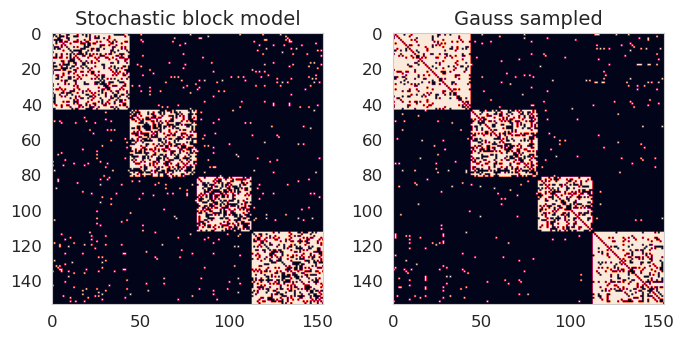

In [66]:
# Compare adjacency
fig, axs = plt.subplots(1, 2)
axs[0].imshow(A_sbm)
axs[0].set_title("Stochastic block model")
axs[1].imshow(Net.adjacency)
axs[1].set_title("Gauss sampled")
if save_folder:
    plt.savefig(save_folder + "/compare_adjacencies.png", bbox_inches='tight')

In [67]:
# Compute curvature
cnx.compute_curvature(c_type='forman')

# Curvature of SBM Graph
frc = FormanRicci(G_sbm, verbose="INFO")
frc.compute_ricci_curvature()


===== Compute the Forman Ricci curvature of the given graph =====
Forman curvature (augmented) computation done.
time elapsed: 0.08172726631164551
Forman curvature (augmented) computation done.


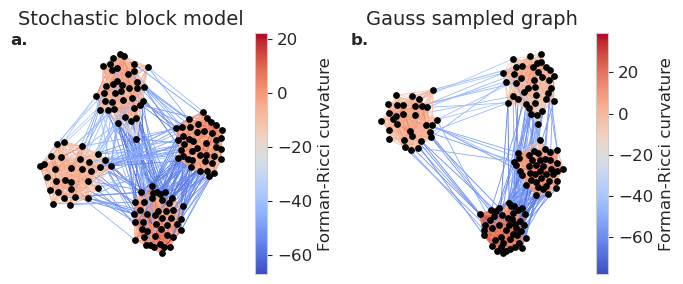

In [68]:
# Plot Forman Curvature in spring layout
plt.figure(figsize=(7, 3))
# SBM graph 
ax = plt.subplot(121)
ax.set_title("Stochastic block model")
colors = [frc.G[u][v]['formanCurvature'] for u, v in frc.G.edges]
vmin = min(colors)
vmax = max(colors)

cmap = cm.coolwarm
my_pos = nx.spring_layout(G_sbm, seed = 32)
nx.draw(G_sbm, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"a.", transform=ax.transAxes, weight='bold')

ax = plt.subplot(122)
ax.set_title("Gauss sampled graph")
colors = [cnx.cnx[u][v]['formanCurvature'] for u, v in cnx.cnx.edges]
vmin = min(colors)
vmax = max(colors)

cmap = cm.coolwarm
cnx_pos = nx.spring_layout(cnx.cnx, seed = 32)
nx.draw(cnx.cnx, pos=cnx_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"b.", transform=ax.transAxes, weight='bold')

if save_folder:
    plt.savefig(save_folder + "/compare_springLayout_sbm_gauss.png", bbox_inches='tight')


number of edges: 2394


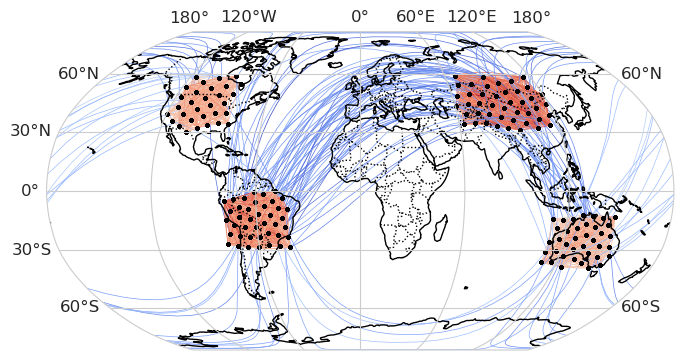

In [69]:
# Plot edges on graph
edgeCurvature = cnx.get_edge_attr_dict('formanCurvature')
el = list(edgeCurvature.keys())
curv = list(edgeCurvature.values())

im = cplt.plot_edges(ds, list(el),
                weights=curv,
                vmin=np.min(curv), vmax=np.max(curv),
                color='coolwarm',
                projection='Robinson',
                central_longitude=0,
                plt_grid=True,
                lw=0.5,
                alpha=1.0,
                plot_points=True,
                figsize=(7,4),
)
im['ax'].set_global()

if save_folder:
    plt.savefig(save_folder + "/graph_on_map.png", bbox_inches='tight')

In [108]:
# Normalize curvature
cnx.normalize_edge_attr(attributes=['formanCurvature'])

# Get quantiles
q_vals = [0.51, 0.49]
cnx.get_node_attr_q(
    edge_attrs=['formanCurvature',
                'formanCurvature_norm'],
    q_values=q_vals, norm=True
)

Store normalized formanCurvature in network.
formanCurvature
Get node attr formanCurvature_norm...
formanCurvature_norm: No nans in nodes, nothing to correct!
Create ds for all attributes present in node 0.
formanCurvature
0.51
Get values 0.51 <= 11.0
0.49
Get values 0.49 <= 11.0
formanCurvature_norm
0.51
Get values 0.51 <= 0.5213675213675213
0.49
Get values 0.49 <= 0.5213675213675213
Create ds for all attributes present in node 0.


<xarray.Dataset>
Dimensions:                     (points: 154)
Coordinates:
    time                        int64 0
  * points                      (points) int64 31 71 117 152 ... 1398 1439 1453
    lon                         (points) float64 72.83 82.72 ... -64.53 -78.33
    lat                         (points) float64 39.27 33.02 ... -23.48 -5.235
Data variables: (12/17)
    weight                      (points) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    formanCurvature             (points) float64 7.0 2.068 ... -4.862 23.85
    formanCurvature_norm        (points) float64 0.453 0.3687 ... 0.2502 0.741
    formanCurvature_q0.5        (points) float64 14.8 16.96 21.86 ... nan 24.89
    formanCurvature_norm_q0.5   (points) float64 0.5863 0.6233 ... nan 0.7589
    formanCurvature_q0.49       (points) float64 -3.133 -15.1 ... -4.862 4.0
    ...                          ...
    formanCurvature_norm_q0.2   (points) float64 -0.4017 -0.7167 ... -0.156 nan
    formanCurvature_norm_q0.8   (points) float64 nan 0.7094 ... nan 0.8162
    formanCurvature_q0.3        (points) float64 -16.57 -41.9 ... -11.39 1.0
    formanCurvature_q0.7        (points) float64 17.8 19.5 23.23 ... nan 26.67
    formanCurvature_norm_q0.3   (points) float64 0.05006 -0.3829 ... 0.3504
    formanCurvature_norm_q0.7   (points) float64 0.6376 0.6667 ... nan 0.7892

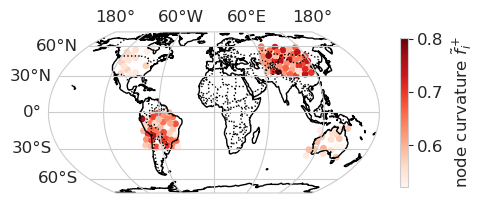

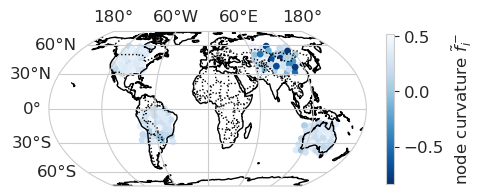

In [116]:
import cartopy.crs as ccrs
vars = [
    dict(var=f'formanCurvature_norm_q{q_vals[0]}',
         vmin=None,
         vmax=None,
         cmap='Reds', label=r"$\tilde{f}_i^+$"),
    dict(var=f'formanCurvature_norm_q{q_vals[1]}',
         vmin=None,
         vmax=None,
         cmap='Blues_r', label=r"$\tilde{f}_i^-$"),
]

for i, v in enumerate(vars):
    fig = plt.figure(figsize=(5,2.5))
    ax = fig.add_subplot(1,1,1,
                            projection=ccrs.EqualEarth(central_longitude=0))
    im = cplt.plot_map(ds, cnx.ds_nx[v['var']],
                  ax=ax,
                  plot_type='scatter',
                  cmap=v['cmap'],
                  projection='PlateCarree',
                  plt_grid=True,
                  vmin=v['vmin'],
                  vmax=v['vmax'],
                  central_longitude=0,
                  size=15, marker='o',
                  bar=False
                  )
    ax.set_global()
    
    cbar = fig.colorbar(
        im['im'],
        ax=ax,
        orientation='vertical',
        label=f"node curvature {v['label']}",
        shrink=0.7
    )

    if save_folder:
        plt.savefig(save_folder + f"/node_{v['var']}_map.svg", bbox_inches='tight')